# Artificial Intelligence II - Homework 4
---
## Part 1
---
### Δημήτριος Σιταράς | 1115201800178
---

## Libraries n' Functions 

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os

In [2]:
!pip install tweet-preprocessor
import string
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import preprocessor as p
nltk.download('wordnet')

def cleaning(text):
    # used to clean urls, mentions (with @), emojis, punctuation marks and all the other symbols that exist
    p.set_options(p.OPT.URL,p.OPT.MENTION)
    text = p.clean(text)
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", text).split())

def stemming(text):
    # used to reduce the inflection in words to their root 
    # SnowBallStemmer used for this job
    SnowStemmer = SnowballStemmer("english")
    stemmedΤokens = [SnowStemmer.stem(token) for token in text.split()]
    return ' '.join(stemmedΤokens)

def lemmatization(text):
    # used to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stringList = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
    return ' '.join([str(element) for element in stringList])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [6]:
def lossCurve(trainLosses,valLosses):
  plt.plot(trainLosses, color="r")
  plt.plot(valLosses, color="g")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train Loss','Validation Loss'])
  plt.show()

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score,auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

def rocCurve(validation_prediction,yValidation):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes=3
  validationPrediction=validation_prediction.detach().numpy()
  yLabelsBin = label_binarize(yValidation, classes=[0,1,2])
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(yLabelsBin[:,i], validationPrediction[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  lw = 2
  colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(n_classes), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

In [8]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 29.3 MB/s 
     |████████████████████████████████| 596 kB 40.6 MB/s 
     |████████████████████████████████| 6.5 MB 33.7 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Data Loading and Preprocessing

In [9]:
Location = r'vaccine_train_set.csv'
trainDf=pd.read_csv(Location)
Location = r'vaccine_validation_set.csv'  # replace this one with the path of test set
validationDf=pd.read_csv(Location)

In [10]:
# preprocessing
trainDf['tweet'] = trainDf['tweet'].apply(cleaning)
trainDf['tweet'] = trainDf['tweet'].apply(lemmatization)
# trainDf['tweet'] = trainDf['tweet'].apply(stemming)

validationDf['tweet'] = validationDf['tweet'].apply(cleaning)
validationDf['tweet'] = validationDf['tweet'].apply(lemmatization)
# validationDf['tweet'] = validationDf['tweet'].apply(stemming)

tweetsTrain=list(trainDf['tweet'])
labelsTrain=list(trainDf['label'])

tweetsVal=list(validationDf['tweet'])
labelsVal=list(validationDf['label'])


## BERT Tokenizer

Προκειμένου στην συνέχεια να χρησιμοποιήσω το pre-trained BERT model,
μέσω του Bert tokenizer, προσθέτω τα special tokens σε κάθε tweet του train και του validation set και παράλληλα κάνω tokenize σε όλα τα tweets σε σταθερό μήκος.

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
xTemp = [tokenizer(text,padding='max_length', max_length = 80) for text in tweetsTrain]

xTrain=[]
xTrainAttentions=[]
for x in xTemp:
  xTrain.append(x['input_ids'])
  xTrainAttentions.append(x['attention_mask'])
  

xTemp = [tokenizer(text,padding='max_length', max_length = 80) for text in tweetsVal]

xVal=[]
xValAttentions=[]
for x in xTemp:
  xVal.append(x['input_ids'])
  xValAttentions.append(x['attention_mask'])


## Build/Load the Bert model

In [13]:
from transformers import BertForSequenceClassification, BertConfig

config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 3 # If config.num_labels > 1 a classification loss is computed (Cross-Entropy).
model = BertForSequenceClassification(config) 
model.parameters
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
from torch.utils.data import TensorDataset, DataLoader

labelsTrain = torch.tensor(labelsTrain)
labelsVal = torch.tensor(labelsVal)
xTrain=torch.tensor(xTrain)
xVal=torch.tensor(xVal)
xTrainAttentions=torch.tensor(xTrainAttentions)
xValAttentions=torch.tensor(xValAttentions)

batch_size = 32

#Initialize dataloader
trainDataset = TensorDataset(xTrain,xTrainAttentions,labelsTrain)
trainDataloader = DataLoader(trainDataset, batch_size=batch_size,shuffle=True)
#Initialize validationloader
valDataset = TensorDataset(xVal,xValAttentions, labelsVal)
valDataloader = DataLoader(valDataset, batch_size=batch_size,shuffle=False)

In [15]:
lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)  

## Train and evalute the Bert model

In [16]:
epochs = 3
trainLosses=[]
valLosses=[]

for i in range(epochs):
    batchLosses = []
    model.train() # training mode
  
    for batch in trainDataloader:
      
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch

      optimizer.zero_grad() # Delete previously stored gradients
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

      batchLosses.append(output[0].item())    

      output[0].backward()  # Perform backpropagation starting from the loss calculated in this epoch
      nn.utils.clip_grad_norm_(model.parameters(),5.0) # Clip gradients to avoid vanishing gradients
      optimizer.step() # Update model's weights based on the gradients calculated during backprop



    trainCurrentLoss = sum(batchLosses)/len(trainDataloader)
    trainLosses.append(trainCurrentLoss) 

    with torch.no_grad(): # evaluation, don't calculate gradients
      model.eval() # evaluation mode
      batchLosses = []
      for batch in valDataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        batchLosses.append(output[0].item())

    valCurrentLoss = sum(batchLosses)/len(valDataloader)
    valLosses.append(valCurrentLoss)
    print("-Epoch: {}/{}...".format(i+1, epochs), "Train Loss: {:.6f} |".format(trainCurrentLoss), "Val Loss: {:.6f}".format(valCurrentLoss))

-Epoch: 1/3... Train Loss: 0.850088 | Val Loss: 0.740775
-Epoch: 2/3... Train Loss: 0.725374 | Val Loss: 0.704658
-Epoch: 3/3... Train Loss: 0.667638 | Val Loss: 0.684862


## Accuracy, Precision, Recall, F1-Score, Support, Loss and Roc Curves 

In [20]:
from sklearn.metrics import classification_report

with torch.no_grad(): # evaluation, don't calculate gradients
  correctPreds = 0
  sum = 0
  model.eval()   
  labels = []   
  validation_predictions = []
  validation_predictionsROC=torch.tensor([])
  for batch in valDataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    validation_predictionsROC=torch.concat([validation_predictionsROC, outputs[0].cpu()], 0)
    predictedLabel = torch.argmax(outputs[0],dim=1)  
    correctPreds += (predictedLabel==b_labels).sum().item()    
    sum += len(b_labels)
    validation_predictions += list(predictedLabel.cpu().detach().numpy())
    b_labels = b_labels.cpu()
    labels += list(b_labels.detach().numpy()) 
    
    
acc = correctPreds / sum
print('Accuracy: {}'.format(acc*100))
print(classification_report(validation_predictions,labels))

Accuracy: 70.72743207712533
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       981
           1       0.16      0.73      0.26        64
           2       0.84      0.62      0.71      1237

    accuracy                           0.71      2282
   macro avg       0.58      0.72      0.58      2282
weighted avg       0.78      0.71      0.73      2282



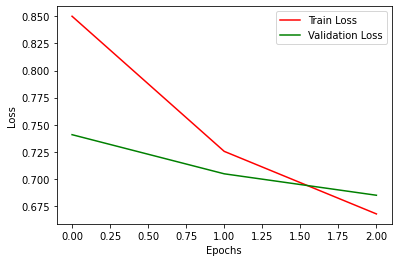

In [21]:
lossCurve(trainLosses,valLosses)

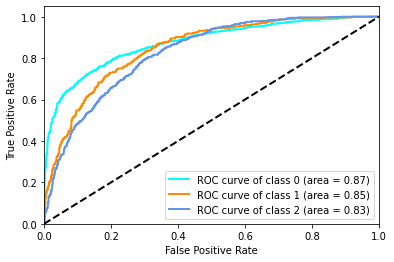

In [19]:
rocCurve(validation_predictionsROC,labels)